<a href="https://colab.research.google.com/github/nahyeon-an/python/blob/main/ML/time-series/TimeSeriesFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Serial Dependence

이전까지의 내용...  
- time index 에서 뽑아내는 time dependent property  

serial dependent property  
- 타겟 시리지의 과거값에 대한 feature 인 경우  
- time 에 따른 관측치 플롯에서 드러나지 않음  
- lag1 타겟 플롯에서 드러난다..?  

## Cycles  

In [ ]:
import pandas as pd

reserve = pd.read_csv(
    "reserve.csv",
    parse_dates={'Date': ['Year', 'Month', 'Day']},
    index_col='Date',
)

reserve.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 904 entries, 1954-07-01 to 2017-03-16
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Federal Funds Target Rate     462 non-null    float64
 1   Federal Funds Upper Target    103 non-null    float64
 2   Federal Funds Lower Target    103 non-null    float64
 3   Effective Federal Funds Rate  752 non-null    float64
 4   Real GDP (Percent Change)     250 non-null    float64
 5   Unemployment Rate             752 non-null    float64
 6   Inflation Rate                710 non-null    float64
dtypes: float64(7)
memory usage: 56.5 KB


In [ ]:
y = reserve.loc[:, 'Unemployment Rate'].dropna().to_period('M')
y.head()

Date
1954-07    5.8
1954-08    6.0
1954-09    6.1
1954-10    5.7
1954-11    5.3
Freq: M, Name: Unemployment Rate, dtype: float64

In [ ]:
df = pd.DataFrame({
    'y': y,
    'y_lag_1': y.shift(1),
    'y_lag_2': y.shift(2),    
})

df.head()

,y,y_lag_1,y_lag_2
Date,,,
1954-07,5.8,NaN,NaN
1954-08,6.0,5.8,NaN
1954-09,6.1,6.0,5.8
1954-10,5.7,6.1,6.0
1954-11,5.3,5.7,6.1


Lag plot  
- lag 에 대비하여 실제 값을 보여주는 플롯  
- Serial dependence 가 잘 나타남  

serial dependence 를 측정하는 방법으로 autocorrelation 이 잘 알려짐  

### Lag 선택하기  
상관관계가 큰 lag 를 항상 모두 피처로 포함시킬 필요 없음  

partial autocorrelation  
- 이전의 모든 lag 들과의 상관관계를 나타냄  
- 부분 상관관계 플롯은 어떤 lag 피처를 사용할지 도와줌  
- partial autocorrelation 의 영역을 벗어나는 lag들을 선택  
- correlogram -> lag feature  

잊지마라  
- autocorrelation 과 partial autocorrelation 은 linear dependence 의 측정 수단일 뿐  
- non-linear 관계는 linear 로 변형 또는 appropriate 알고리즘으로 학습 가능  

In [ ]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

In [ ]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

In [ ]:
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')

    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [ ]:
flu_trends = pd.read_csv("flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

flu_trends.head()

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180
2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,8,...,16,6,9,24,28,25,25,25,9,132
2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,15,...,8,5,12,21,26,26,29,24,13,109
2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,15,...,8,8,12,33,29,21,27,30,9,120


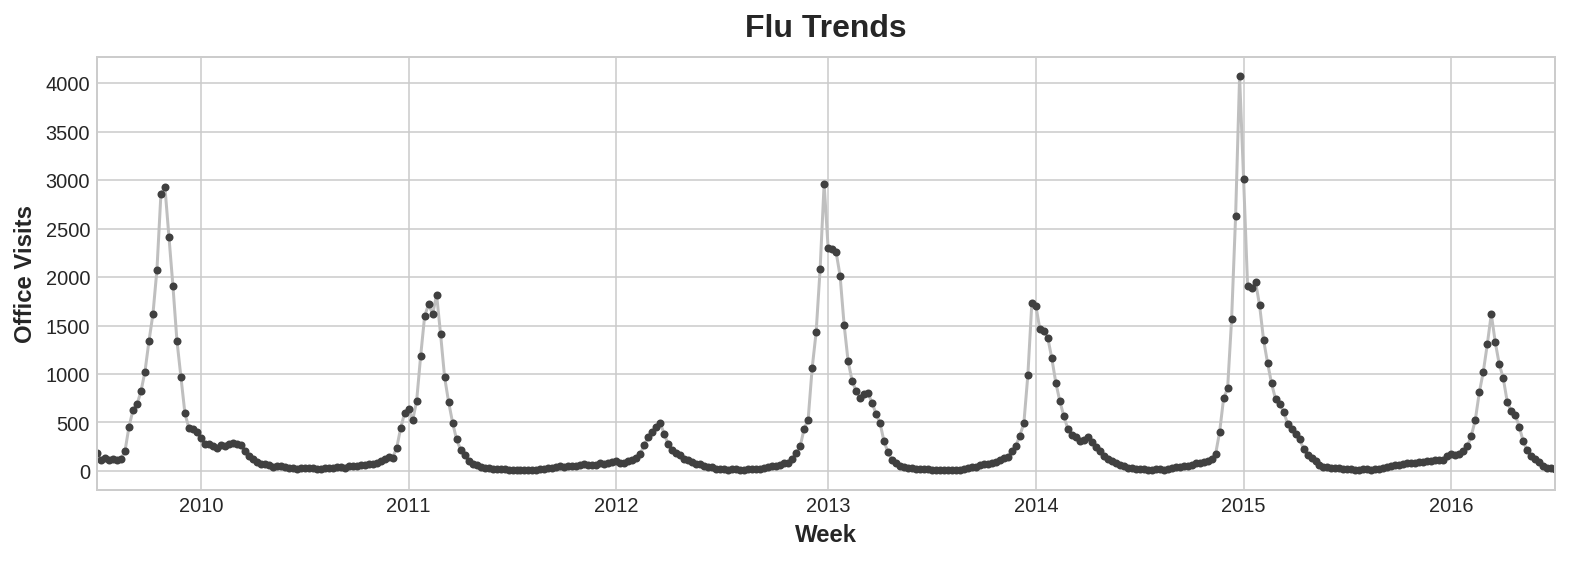

In [ ]:
ax = flu_trends.FluVisits.plot(title='Flu Trends', **plot_params)
_ = ax.set(ylabel="Office Visits")

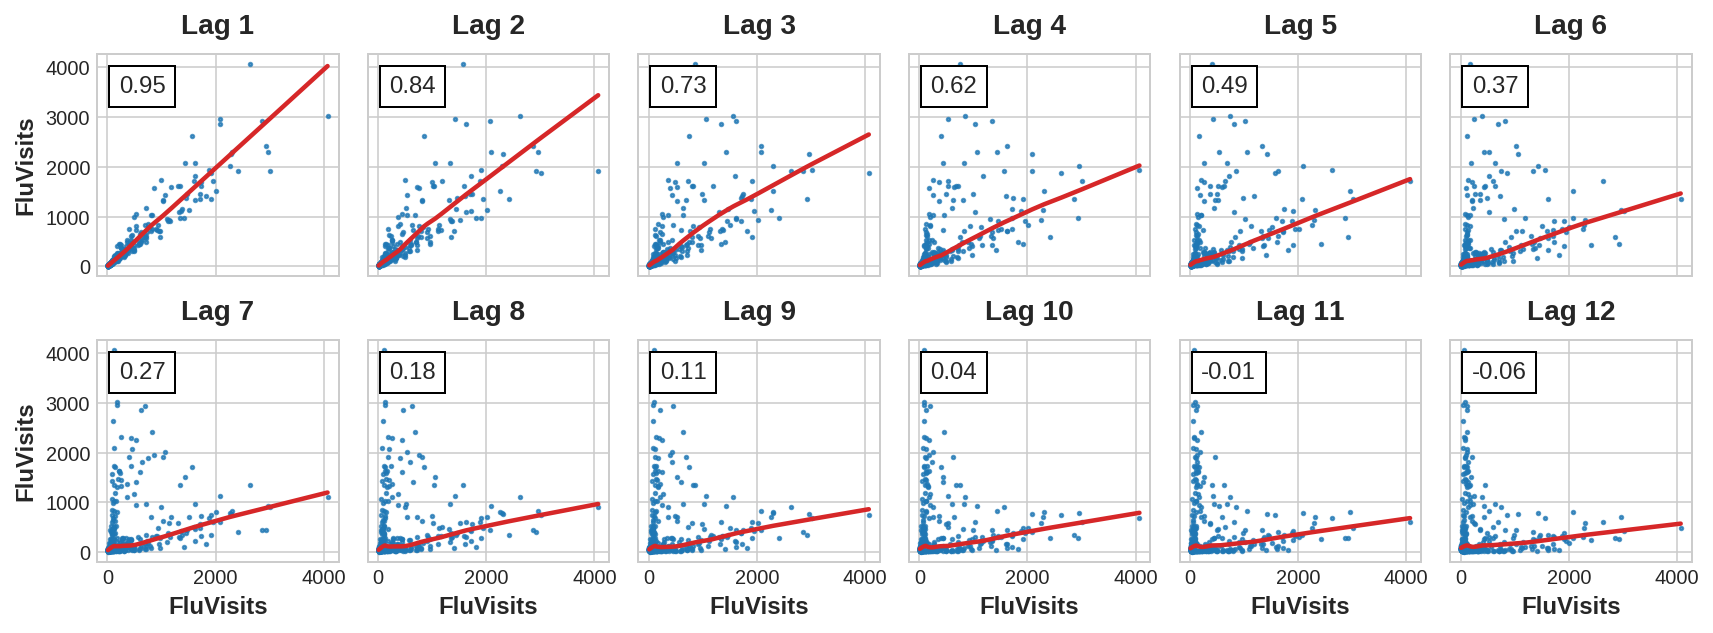

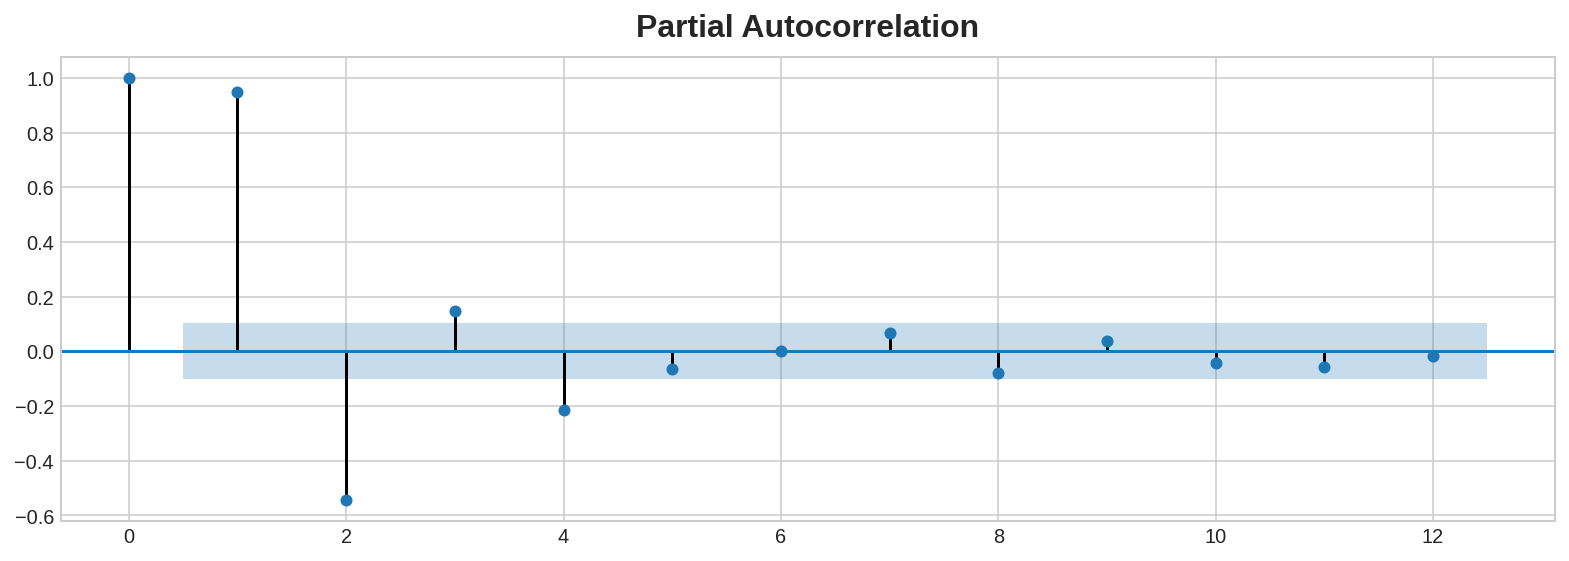

In [ ]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)
_ = plot_pacf(flu_trends.FluVisits, lags=12)

In [ ]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(flu_trends.FluVisits, lags=4)
X = X.fillna(0.0)

In [ ]:
# Create target series and data splits
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

X_train.head(), y_train.head()

(                       y_lag_1  y_lag_2  y_lag_3  y_lag_4
 Week                                                     
 2009-06-29/2009-07-05      0.0      0.0      0.0      0.0
 2009-07-06/2009-07-12    180.0      0.0      0.0      0.0
 2009-07-13/2009-07-19    115.0    180.0      0.0      0.0
 2009-07-20/2009-07-26    132.0    115.0    180.0      0.0
 2009-07-27/2009-08-02    109.0    132.0    115.0    180.0, Week
 2009-06-29/2009-07-05    180
 2009-07-06/2009-07-12    115
 2009-07-13/2009-07-19    132
 2009-07-20/2009-07-26    109
 2009-07-27/2009-08-02    120
 Freq: W-SUN, Name: FluVisits, dtype: int64)

In [ ]:
# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

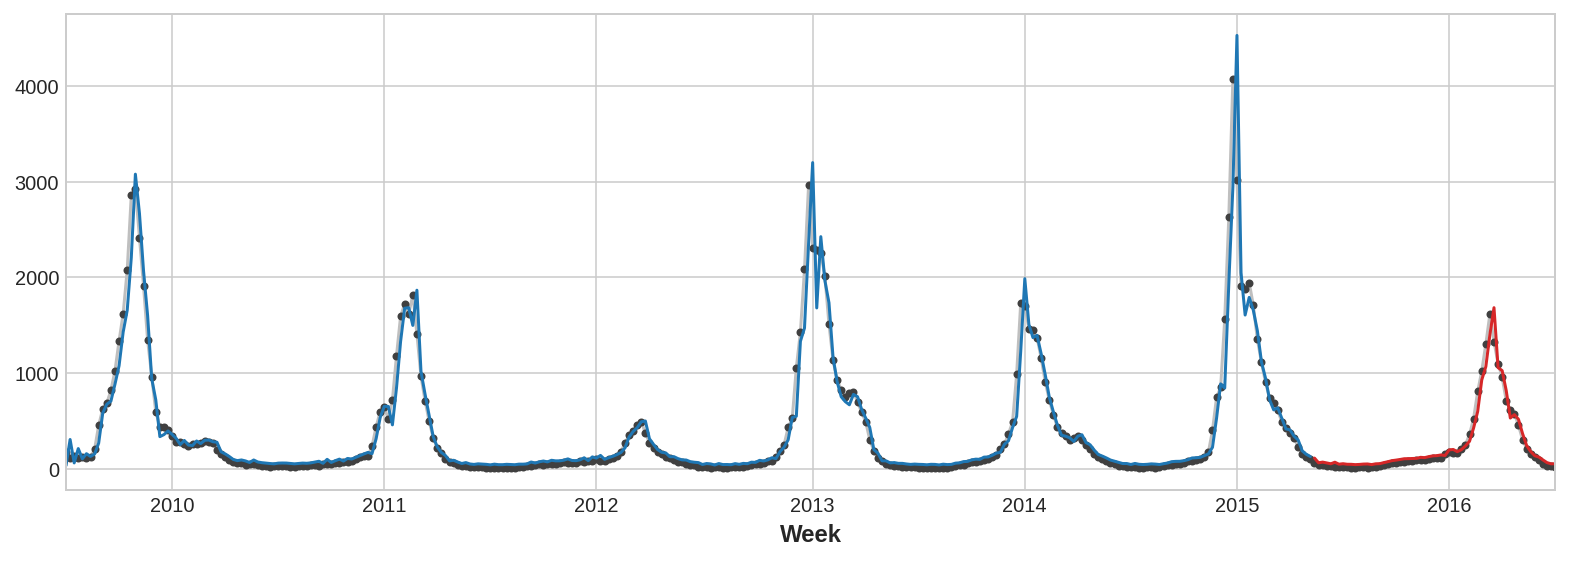

In [ ]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

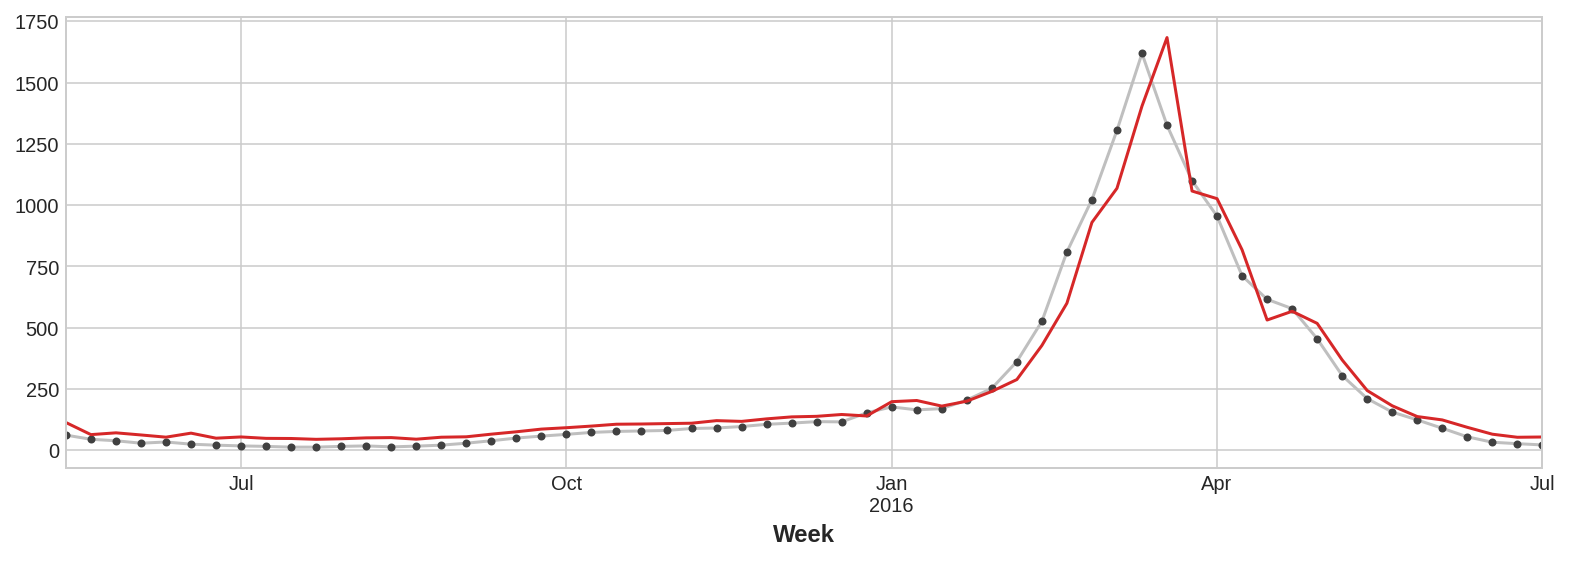

In [ ]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

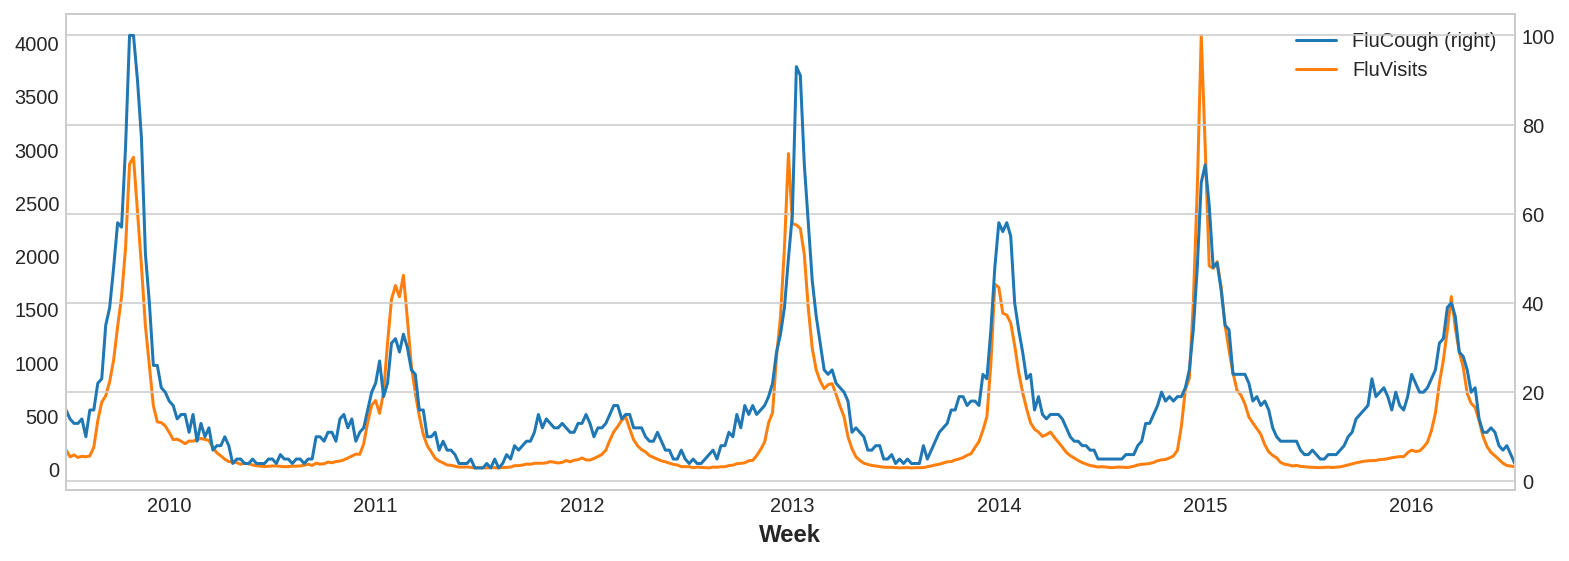

In [ ]:
ax = flu_trends.plot(
    y=["FluCough", "FluVisits"],
    secondary_y="FluCough",
)

In [ ]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

# Create three lags for each search term
X0 = make_lags(flu_trends[search_terms], lags=3)

# Create four lags for the target, as before
X1 = make_lags(flu_trends['FluVisits'], lags=4)

# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(0.0)

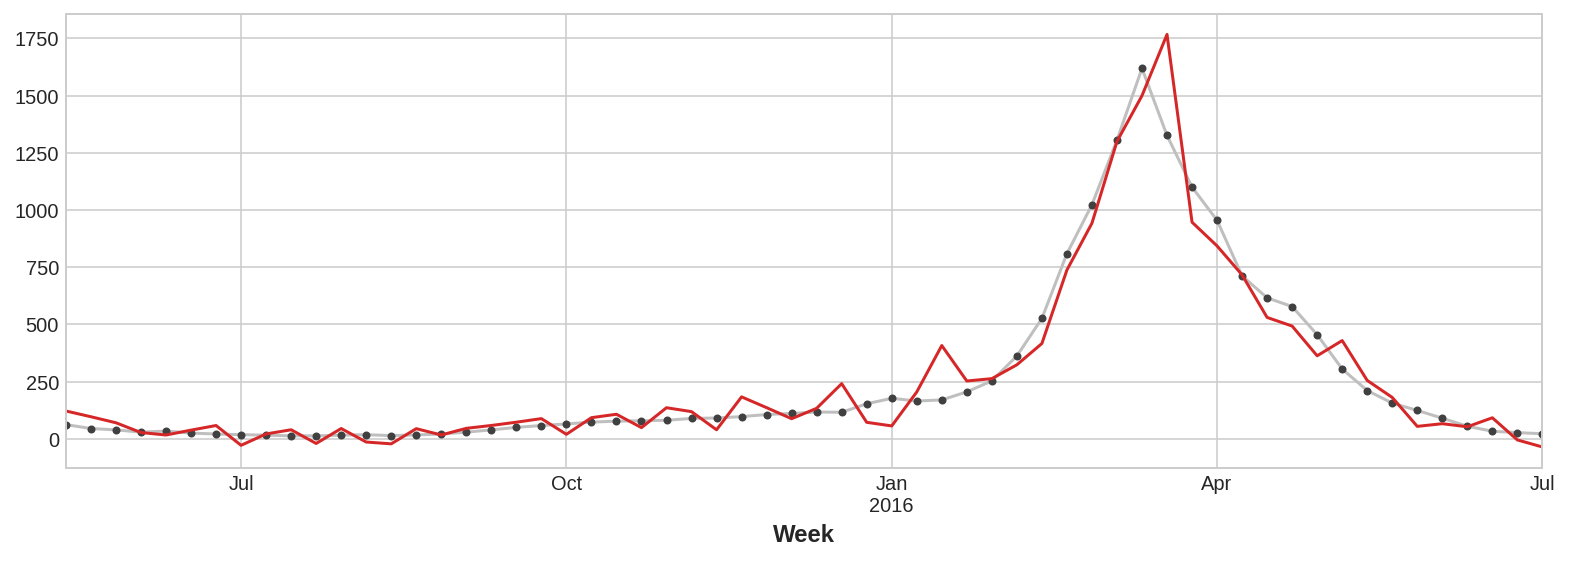

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

## Exercise

In [1]:
!pip install statsmodels==0.13.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 7.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [3]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [4]:
store_sales = pd.read_csv(
    'train.csv', 
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': pd.Int64Dtype(),
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

In [5]:
store_sales.head(1)

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0


In [6]:
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales.head(1)

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0


In [7]:
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
store_sales.head(1)

,,,sales,onpromotion
store_nbr,family,date,,
1,AUTOMOTIVE,2013-01-01,0.0,0


In [8]:
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)
family_sales.head(2)

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   

                                                                      \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS  PRODUCE   
date                                                                   
2017-01-01                     0.0       0.0       0.037037  0.12963   
2017-01-02                     0.0  0.259259       1.166667  5.62963   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0       0.0  
2017-01-02                        0.0  0.407407  

[2 rows x 66 columns]

모든 상품 집단이 cycle 을 보이지는 않음  
school, office 의 판매는 성장 패턴은 보이고, 트렌드/계절성에 의한 감소는 잘 안 보임  
이럴 때, lag feature 를 이용하여 cycle 을 모델링해보자  

cycle 을 고립시키기 위해, deseasonalize 부터 시작하자  

In [9]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()
y.head(1)

date
2017-01-01    0.0
Freq: D, Name: SCHOOL AND OFFICE SUPPLIES, dtype: float32

In [10]:
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier]
)
X_time = dp.in_sample()
X_time.head(1)

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [11]:
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)
X_time.head(1)

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",NewYearsDay
date,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,True


Text(0.5, 1.0, 'Sales of School and Office Supplies (deseasonalized)')

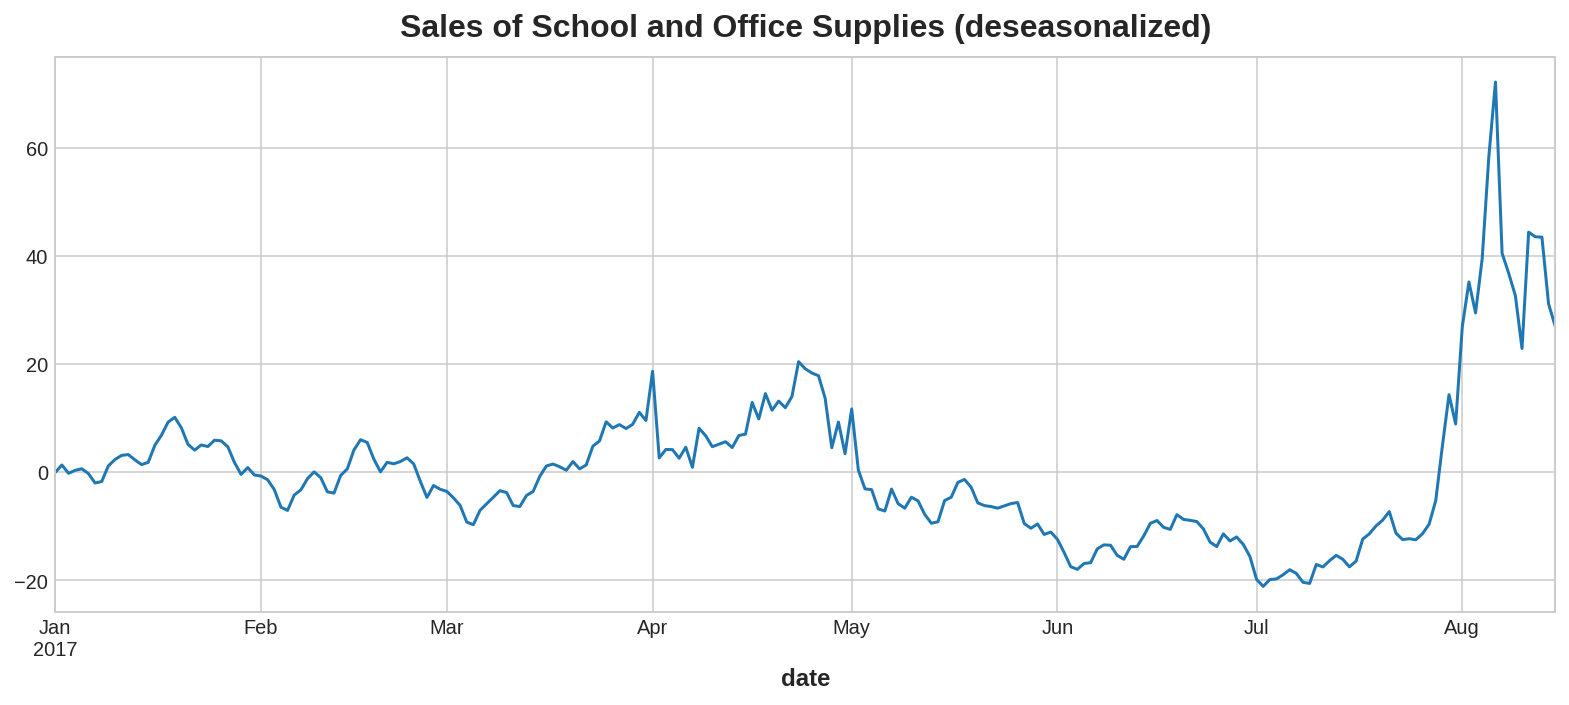

In [12]:
model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)

y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)")

### 1) plot cycles  
moving average 를 이용하여 cycle 을 플롯팅 해보자  
- long enough to smooth over short-term seasonality  
- short enough to preserve cycle  

Text(0.5, 1.0, 'Seven-Day Moving Average')

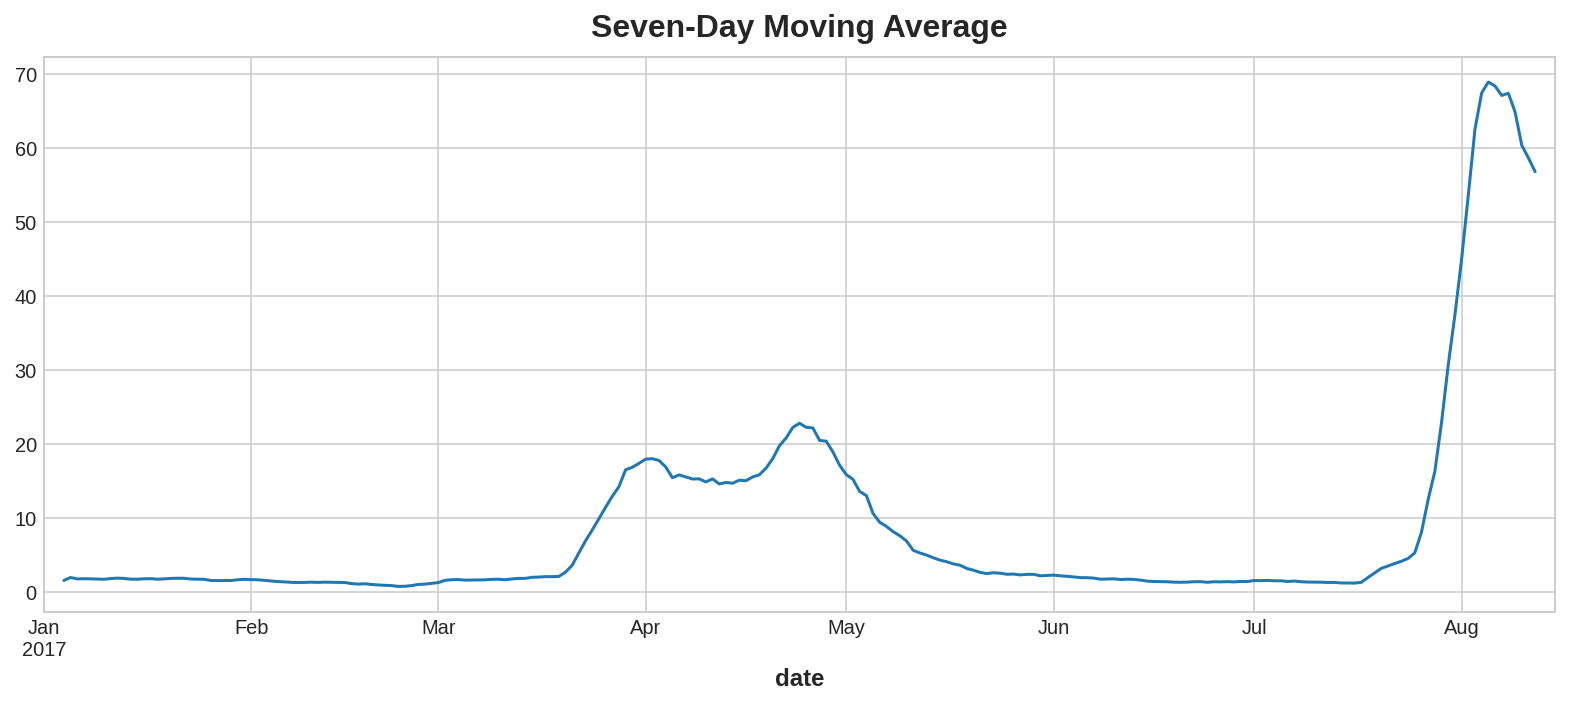

In [13]:
y_ma = y.rolling(
    window=7,
    center=True
).mean()

ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average")

위의 moving average plot 이 deseasoned plot 이 유사함  
모두 cycle 을 확인할 수 있다 

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


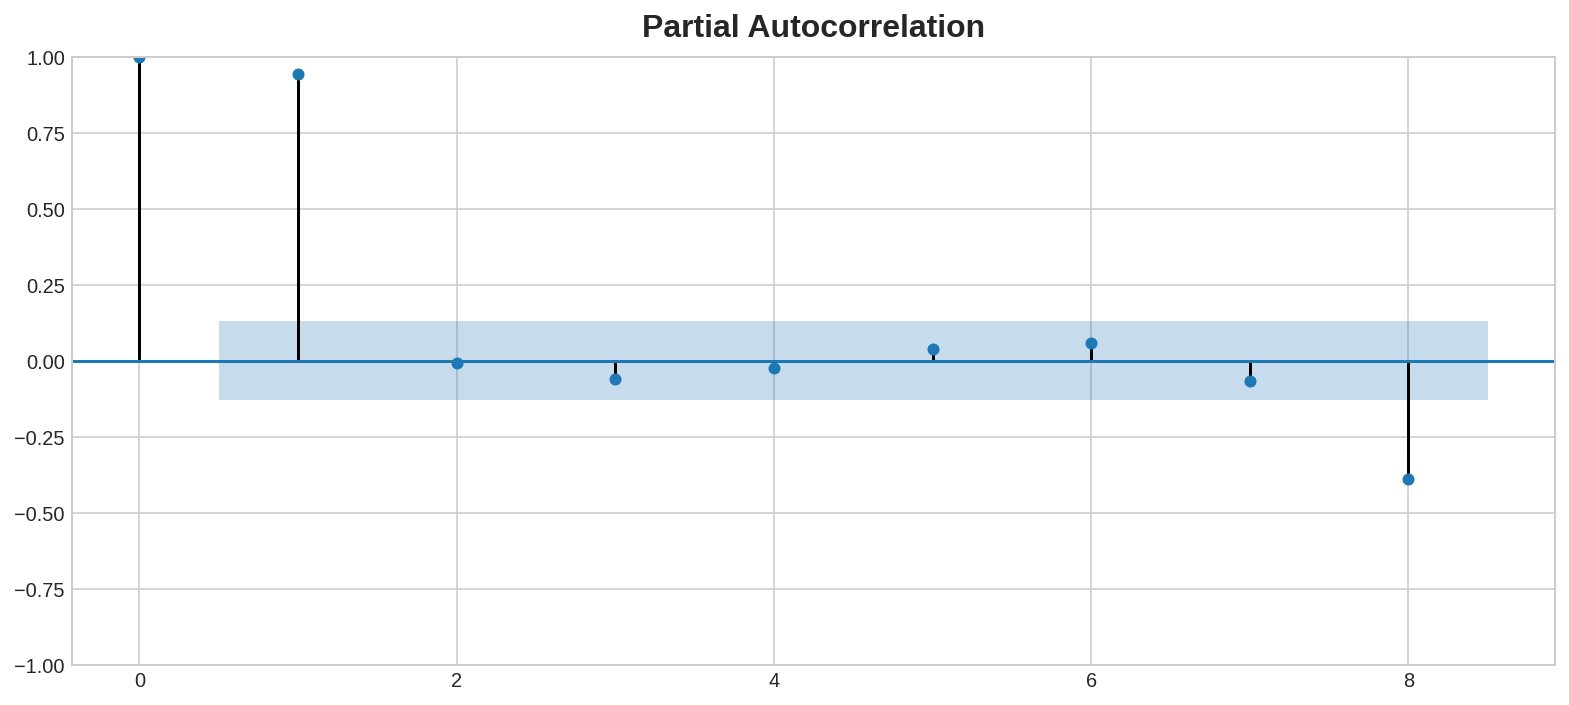

In [15]:
_ = plot_pacf(y_deseason, lags=8)

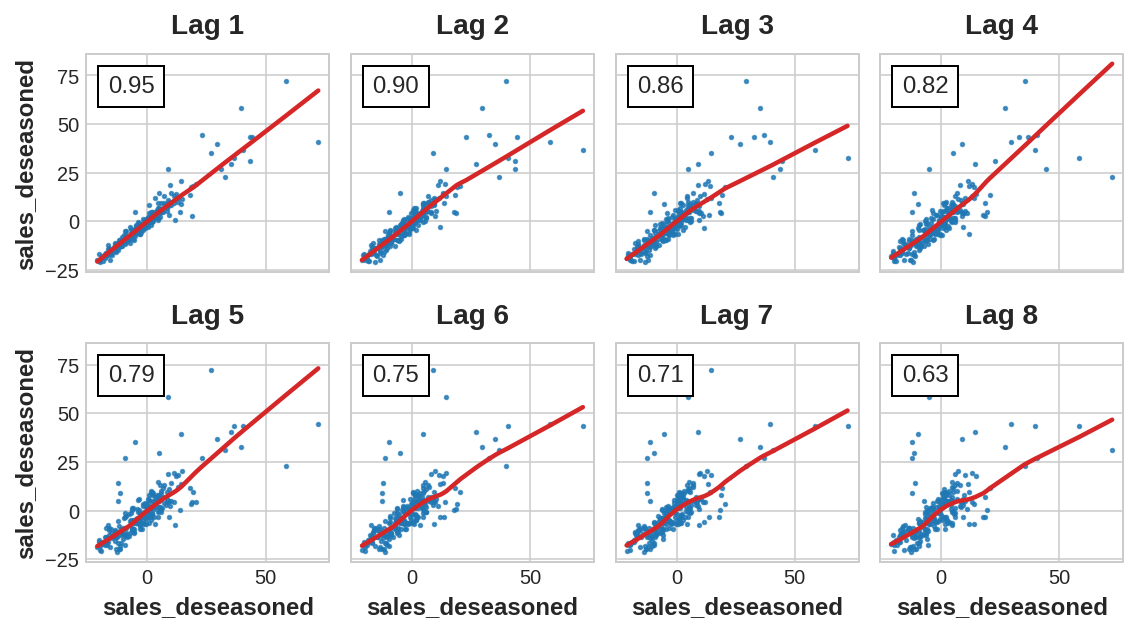

In [21]:
def lagplot(x, y=None, shift=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(shift)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    title = f"Lag {shift}" if shift > 0 else f"Lead {shift}"
    ax.set(title=f"Lag {shift}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x,
              y=None,
              lags=6,
              leads=None,
              nrows=1,
              lagplot_kwargs={},
              **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    orig = leads is not None
    leads = leads or 0
    kwargs.setdefault('ncols', math.ceil((lags + orig + leads) / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        k -= leads + orig
        if k + 1 <= lags:
            ax = lagplot(x, y, shift=k + 1, ax=ax, **lagplot_kwargs)
            title = f"Lag {k + 1}" if k + 1 >= 0 else f"Lead {-k - 1}"
            ax.set_title(title, fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

_ = plot_lags(y_deseason, lags=8, nrows=2)

### 2) serial dependece 조사  
correlogram 을 통해 중요한 lag 는 무엇인지?   
lag plot 에서 알아낼 수 있는 관계?  

correlogram 을 통해 lag 1 과 lag 8 이 영향력이 있음을 확인 가능  
lag plot 에서 lag1 과 lag8 모두 linear effect 임을 확인 가능  

#### Leading Indicator  
어떤 순간의 값이 미래 시간의 카겟을 예측하는 데에 사용되는 시리즈  
타겟의 변화에 대한 advance notice 를 제공함  

현재 데이터셋은 leading indicator 로써 유용한 타임 시리즈를 포함하고 있음  
onpromotion series  
- 프로모션 날에 판매된 물량, 아이템 수  

따라서, 화요일 onpromotion 값을 월요일 판매량 예측을 위해 사용할 수 있음  

In [17]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')
onpromotion.head(1)

date
2017-01-01    0.0
Freq: D, Name: onpromotion, dtype: Float64

In [28]:
X = onpromotion.loc[onpromotion > 1].to_frame()
Y = y_deseason.loc[onpromotion > 1].to_frame()

ValueError: ignored

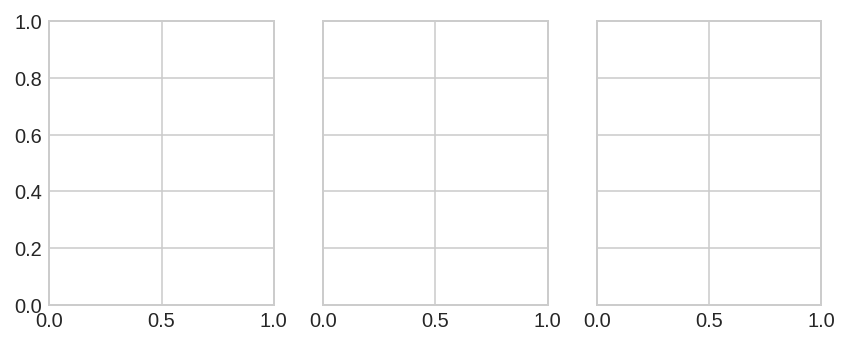

In [29]:
plot_lags(x=X, y=Y, lags=3, nrows=1)

### 3) Time Series Feature 를 조사  
onpromotion 시리즈의 leading value 또는 lagging value 가 피처로써 유용한가? 

lag plot 에서 onpromotion 의 leading value 와 lagged value 모두 판매량과 상관관계가 있음을 보여준다.  
즉, 두 값 모두 유용하다.  
non-linear effect 또한 존재한다.  

### 4) Time Series Feature 만들기  

In [19]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [20]:
X_lags = make_lags(y_deseason, lags=1)
X_lags.head(1)

,y_lag_1
date,
2017-01-01,NaN


In [30]:
def make_leads(ts, leads, name='y'):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(leads))},
        axis=1)

In [31]:
X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion,
    make_leads(onpromotion, leads=1)
], axis=1)

In [32]:
X_promo.head(1)

,y_lag_1,onpromotion,y_lead_0
date,,,
2017-01-01,<NA>,0.0,0.0


In [33]:
X = pd.concat([X_lags, X_promo], axis=1).dropna()
y, X = y.align(X, join='inner')

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:976: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  estimator=estimator,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X

In [35]:
y_fit, y_pred

(date
 2017-01-02    7.688033e-18
 2017-01-03    1.179651e-02
 2017-01-04    0.000000e+00
 2017-01-05    3.269589e-03
 2017-01-06    5.757536e-03
                   ...     
 2017-07-12    0.000000e+00
 2017-07-13    0.000000e+00
 2017-07-14    0.000000e+00
 2017-07-15    0.000000e+00
 2017-07-16    0.000000e+00
 Freq: D, Length: 196, dtype: float64, date
 2017-07-17     0.000000
 2017-07-18     0.000000
 2017-07-19     0.000000
 2017-07-20     0.000000
 2017-07-21     0.000000
 2017-07-22     0.000000
 2017-07-23     0.000000
 2017-07-24     0.404370
 2017-07-25     0.000000
 2017-07-26     0.062714
 2017-07-27     4.319147
 2017-07-28     6.538660
 2017-07-29    11.189842
 2017-07-30    11.007128
 2017-07-31    10.876700
 2017-08-01    15.801456
 2017-08-02    16.028492
 2017-08-03    17.040286
 2017-08-04    16.181245
 2017-08-05    18.059849
 2017-08-06    17.500144
 2017-08-07    19.560899
 2017-08-08    18.371719
 2017-08-09    19.447962
 2017-08-10    21.505213
 2017-08-11    21

In [36]:
rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5

print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

Training RMSLE: 0.83417
Validation RMSLE: 1.17316


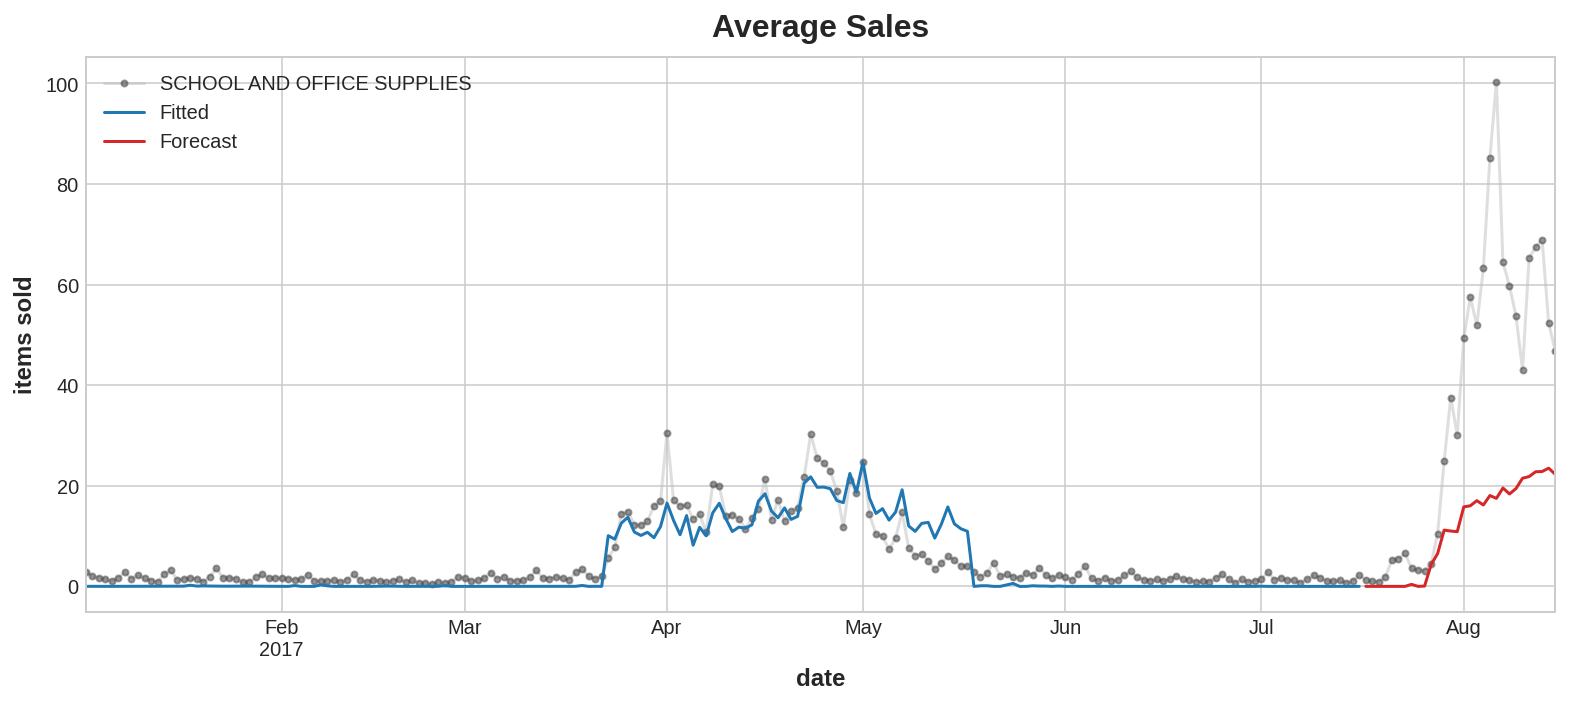

In [37]:
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend()

kaggle 의 forecasting competition 우승자들은 주로 moving average 와 다른 rolling 통계법을 feature set 에 많이 적용함  
특히 GBDT (ex. XGBoost) 알고리즘들과 함께 사용할 때 유용함

rolling statistic 을 피처로 사용하는 것은 lookahead leakage 를 피하기 위한 효과와 유사한 것이다.  
먼저, 결과는 window 의 오른쪽 끝에 위치해야 한다. (center = False)  
다음은, 타겟을 step 만큼 지연시키는 것이다. 

### 5) Statistical feature 를 생성하기  

다음 통계 피처들을 생성해보자  
14-day rolling median of lagged target  
7-day rolling standard deviation of lagged target  
7-day sum of items "on promotion", with centered window  

In [38]:
y_lag = supply_sales.loc[:, 'sales'].shift(1)
onpromo = supply_sales.loc[:, 'onpromotion']

In [39]:
mean_7 = y_lag.rolling(7).mean()
median_14 = y_lag.rolling(14).median()
std_7 = y_lag.rolling(7).std()
promo_7 = onpromo.rolling(7, center=True).sum()

rolling() 함수와 관련하여 exponential weighted window 를 적용할 수도 있다.  
exponential decay 가 좀 더 현실에서 관찰되는, 시간에 따라 영향이 전파되는 방식임  